In [1]:
import pandas as pd
import json
import requests
import datetime

In [2]:
url = " https://seeclickfix.com/api/v2/issues?min_lat=39.03211937423035&min_lng=-95.71889877319336&max_lat=39.052118348329074&max_lng=-95.6312656402588&status=open%2Cacknowledged%2Cclosed&fields%5Bissue%5D=id%2Csummary%2Cdescription%2Cstatus%2Clat%2Clng%2Caddress%2Cmedia%2Ccreated_at%2Cacknowledged_at%2Cclosed_at&page=1"

In [3]:
response = requests.get(url).json()
total_pages = response['metadata']['pagination']['pages']

In [4]:
def get_issues(url):
    all_issues = []
    for i in range(1,total_pages +1):
        print(f"getting page {i} of {total_pages}")
        response = requests.get(url).json()
        next_page_url = response['metadata']['pagination']['next_page_url']
        page_issues = response['issues']
        all_issues.extend(page_issues)
        url = next_page_url
    return all_issues

In [5]:
all_issues = get_issues(url)

getting page 1 of 10
getting page 2 of 10
getting page 3 of 10
getting page 4 of 10
getting page 5 of 10
getting page 6 of 10
getting page 7 of 10
getting page 8 of 10
getting page 9 of 10
getting page 10 of 10


In [6]:
issues_df = pd.DataFrame(all_issues)
issues_df = issues_df.set_index('id')

def clean_summary(df):
    df['created_at'] = pd.to_datetime(df['created_at'], format="%Y/%m/%d",utc=True)
    df['acknowledged_at'] = pd.to_datetime(df['acknowledged_at'], format="%Y/%m/%d",utc=True)
    df['closed_at'] = pd.to_datetime(df['closed_at'], format="%Y/%m/%d",utc=True)
    df['time to acknowledge'] =df['acknowledged_at' ] - df['created_at' ]


    return df.replace({"Curb and Gutter": "Curb and Gutter Repair",
                      "Junk Yard?":"Property Maintenance & Code Violations",
                     "skatepark light":"safety lighting",
                     "Dead animal on sidewalk ":"Police Animal Control",
                    "Loud pedestrian crossing ": "Street Sign Repair",
                     "Pothole":"Street Repair"})
issues_df = clean_summary(issues_df)

In [7]:
status_list = issues_df['status'].value_counts()

In [8]:
summary_list = issues_df['summary'].value_counts()
summary_list

Property Maintenance & Code Violations    55
Curb and Gutter Repair                    44
Street Repair                             17
Alley                                     14
Sidewalk and Ramp                         10
Police General Issue                       8
Trees and Tree Limbs                       8
General Feedback or Questions              4
Other                                      4
Snow or Ice Hazard                         3
Street Sign Repair                         3
safety lighting                            2
Utility Work Damage                        2
Police Animal Control                      2
Graffiti                                   1
Downtown Parking General Question          1
Loud pedestrian crossing                   1
Hole in Buffalo                            1
Hydrant Leaking                            1
dangerous parking                          1
Name: summary, dtype: int64

In [9]:
summary_df = pd.DataFrame(issues_df.groupby('summary')['status'].count())

<AxesSubplot:xlabel='summary'>

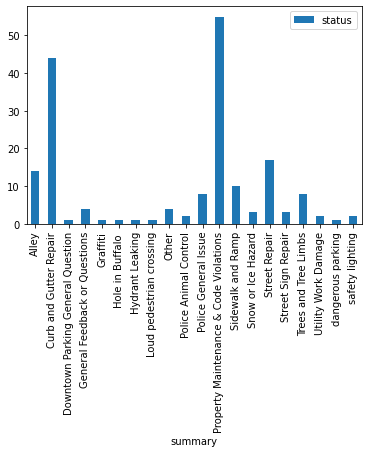

In [10]:
summary_df.plot(kind="bar")

<AxesSubplot:xlabel='status'>

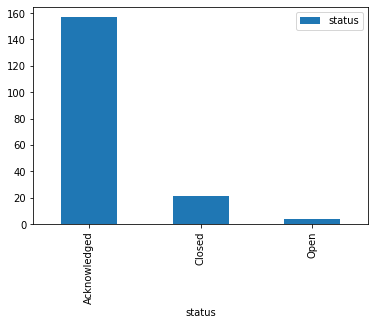

In [11]:
status = pd.DataFrame(issues_df.groupby('status')['status'].count())
status.plot(kind="bar")

In [34]:
issues_df['time to acknowledge'].days

AttributeError: 'Series' object has no attribute 'days'

In [29]:
issues_df.groupby('time to acknowledge')['time to acknowledge'].count()

time to acknowledge
0 days 00:00:02       4
0 days 00:00:03       4
0 days 00:00:04      19
0 days 00:00:05      19
0 days 00:00:06       6
0 days 00:00:07      12
0 days 00:00:08       4
0 days 00:00:09       1
0 days 00:00:10       3
0 days 00:00:11       5
0 days 00:00:12       3
0 days 00:00:13       5
0 days 00:00:14       8
0 days 00:00:15       3
0 days 00:00:16       4
0 days 00:00:17       5
0 days 00:00:18       2
0 days 00:00:19       6
0 days 00:00:20       4
0 days 00:00:21       2
0 days 00:00:22       4
0 days 00:00:23       4
0 days 00:00:24       5
0 days 00:00:25       4
0 days 00:00:26       2
0 days 00:00:27       2
0 days 00:00:28       1
0 days 00:00:29       2
0 days 00:00:32       3
0 days 00:00:33       3
0 days 00:00:34       1
0 days 00:00:36       3
0 days 00:00:37       2
0 days 00:00:38       1
0 days 00:00:39       2
0 days 00:00:40       2
0 days 00:00:42       2
0 days 00:00:45       1
0 days 00:00:48       1
0 days 00:01:20       1
0 days 00:01:26     

In [32]:
pd.to_datetime(issues_df['time to acknowledge'] )

TypeError: dtype timedelta64[ns] cannot be converted to datetime64[ns]